Source: https://huggingface.co/docs/transformers/quicktour#trainer

In [1]:
%%capture
!pip install "sagemaker>=2.250.0" "transformers>=4.55.2" "datasets==4.0.0" "accelerate>=0.26.0"

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, logging
from datasets import load_dataset
from transformers import DataCollatorWithPadding

In [3]:
logging.enable_progress_bar()  
logging.set_verbosity_info()

In [4]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
dataset = load_dataset("rotten_tomatoes")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /home/ec2-user/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.55.2",
  "vocab_size": 30522
}



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /home/ec2-user/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
Some weights of the model checkpoint at distilbert/distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Dist

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /home/ec2-user/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.55.2",
  "vocab_size": 30522
}



vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

loading file vocab.txt from cache at /home/ec2-user/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /home/ec2-user/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/ec2-user/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /home/ec2-user/.cache/huggingface/hub/models--distilbert--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectur

README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [5]:
def tokenize_dataset(dataset):
    return tokenizer(dataset["text"])
dataset = dataset.map(tokenize_dataset, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
training_args = TrainingArguments(
    output_dir="distilbert-rotten-tomatoes",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    # push_to_hub=True,
    do_eval=True,
    eval_strategy="steps",
    eval_steps=500,
    report_to='all',
    average_tokens_across_devices=False
)

PyTorch: setting up devices


In [22]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=500,
eval_strategy=steps,
eval_use_gather_object=False,
fp16=False,
fp16

In [23]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
    # compute_metrics=compute_metrics,
    data_collator=data_collator,
    # can_return_loss=True
)

trainer.train()

The following columns in the Training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8,530
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4,268
  Number of trainable parameters = 66,955,010


Step,Training Loss,Validation Loss
500,0.021700,1.687629
1000,0.044600,1.259988
1500,0.025300,1.611998
2000,0.055500,1.330241
2500,0.066200,1.328099
3000,0.044600,1.323048


The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1066
  Batch size = 8
Saving model checkpoint to distilbert-rotten-tomatoes/checkpoint-500
Configuration saved in distilbert-rotten-tomatoes/checkpoint-500/config.json
Model weights saved in distilbert-rotten-tomatoes/checkpoint-500/model.safetensors
tokenizer config file saved in distilbert-rotten-tomatoes/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-rotten-tomatoes/checkpoint-500/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you ca

SafetensorError: Error while serializing: I/O error: No space left on device (os error 28)

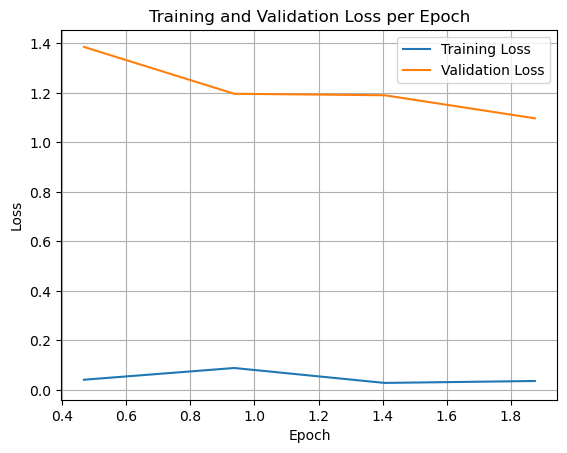

In [20]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()